<a href="https://colab.research.google.com/github/sharsulkar/H1B_LCA_outcome_prediction/blob/main/prototyping/notebooks/04_sh_select_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model selection and HyperParameter tuning  
In this notebook, a ML model will be selected based on its performance on validation and test dataset and it will be tuned further to get the best performance.  


In [1]:
#import required libraries
import pandas as pd
import numpy as np
np.random.seed(42)
import random
from sklearn.metrics import plot_confusion_matrix,confusion_matrix
import matplotlib.pyplot as plt 
from sklearn.metrics import f1_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, IsolationForest
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import time
%matplotlib inline

### Source data
The preprocessed data is stored in memory for ease of use during prototyping. Load the data into a dataframe.

In [2]:
#import features from saved file 
processed_df=pd.read_csv('/content/drive/MyDrive/Datasets/LCA_train_q1q2processed.csv',index_col=0)
Y=pd.read_csv('/content/drive/MyDrive/Datasets/LCA_train_q1q2_expected.csv',index_col=0)
processed_df.shape

(256141, 31)

In [3]:
#Add the target column back to processed_df as it will be used in generate_train_val_batches function
Y.replace(['Certified','Denied'],[0,1],inplace=True)
processed_df['CASE_STATUS']=Y

In [4]:
#check that the output class has expected value
Y.groupby('CASE_STATUS').size()

CASE_STATUS
0    254227
1      1914
dtype: int64

### Model Training  
This problem can be solved using mutiple approaches, each of which will be tested below. The approaches and the models used are as below -  
1. As this is a binary classification problem for which linear classifiers like SVM and Logistic classifier can be used.  
2. The dataset is highly unbalanced in favor of class 0 (Class='Confirmed') with less than 1% of data available for class 1 (Class='Denied'). So this can be solved as a Anomaly detection problem. Isolation forest and one class SVM models can be used.
3. This can be considered as a clustering problem for which Kmeans can be used.
4. Tree based algorithms work well for classification problems and to handle data with this complexity, Random Forest and AdaBoost Classifiers can be used.  
5. Non-linear SVM classifiers with rbf, poly and sigmoid kernels.  

In addition to this, below approaches as used for training these models -  
1. Batch training with equal class distribution - All minority class samples (class 1) are available for training and an equal number of samples are chosen at random from the majority class (Class 0) for each iteration. The models are trained for multiple iterations using such dataset.  
2. Training with full unbalanced dataset.  

In [5]:
def generate_train_val_batches(df,class_0_index,class_1_index,class_count,batch_size,val_size):
  #Generate batches to output training and val data 
  #randomly select indexes of batch size/class_count from the index collection for the entire dataset
  idx_0=random.sample(set(class_0_index.values),int(batch_size/class_count)) 
  idx_1=random.sample(set(class_1_index.values),int(batch_size/class_count))

  #split the indexes into train and val datasets within the selected batch
  split_value=int((batch_size*val_size)/class_count)
  idx_train=idx_0[split_value:]+idx_1[split_value:]
  idx_val=idx_0[:split_value]+idx_1[:split_value]

  #Generate the train and val datasets using the indexes selected in previous step
  X_train=df.loc[idx_train]
  X_val=df.loc[idx_val].reset_index(drop=True)
  y_val=X_val.pop('CASE_STATUS').astype(int)
  #https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
  X_train=X_train.sample(frac=1).reset_index(drop=True)
  y_train=X_train.pop('CASE_STATUS').astype(int)

  return X_train, y_train, X_val, y_val

Split the preprocessed data into training and validation set to prevent data leakage during batch training. This will also ensure that all approaches that are being tested for model selection are validated against the same validation dataset.

In [6]:
#create train and validation set
train_df,val_df=train_test_split(processed_df,test_size=0.1,stratify=processed_df['CASE_STATUS'])
train_df.reset_index(inplace=True, drop=True)
val_df.reset_index(inplace=True, drop=True)
y_val=val_df.pop('CASE_STATUS')
#y_val.shape

In [ ]:
#collection of indexes for both classes from the entire training dataset
class_0_index=train_df[train_df.CASE_STATUS==0].index 
class_1_index=train_df[train_df.CASE_STATUS==1].index
#skewness between classes - class 1 is only 0.7% of total
print('Class skew:',class_1_index.shape[0]*100/(class_0_index.shape[0]+class_1_index.shape[0]))

Class skew: 0.7474211151887422


#### Initialize models

In [29]:
#linear classifiers
svc=SGDClassifier(loss='hinge')
logistic=SGDClassifier(loss='log')
#tree based
adaboost=AdaBoostClassifier()
rfc=RandomForestClassifier()
#clustering
kmeans=KMeans(n_clusters=2)
#anomaly detection
iforest=IsolationForest(contamination=0.01)
ocsvm=OneClassSVM(kernel = 'rbf', gamma = 0.001, nu = 0.001)
#non-linear SVC
svc_rbf=SVC(kernel='rbf')
svc_poly=SVC(kernel='poly')
svc_sigm=SVC(kernel='sigmoid')

In [32]:
model_performance_df=pd.DataFrame(columns=['model_name','training_approach','class0_score','class1_score','processing_time(s)'])

#### Batch training and validation

In [ ]:
#algorithm to create mini batches where each batch has a equal distribution of both classes
class_count=2 #number of classes to predict
batch_size=3400 #batch size of train+val dataset
val_size=0 #validation data % within batch

#loop over 
for model in [svc,logistic,adaboost,rfc,kmeans,iforest,ocsvm,svc_rbf,svc_poly,svc_sigm]:
  start = time.time()
  for _ in range(100):
    X_train, y_train,_,_ = generate_train_val_batches(train_df,class_0_index,class_1_index,class_count,batch_size,val_size)
  
    #train classifiers on batches
    model.fit(X_train,y_train)
  model_score=f1_score(y_true=y_val,y_pred=model.predict(val_df),average=None)
  elapsed_time = (time.time() - start)
  model_performance_df.loc[model_performance_df.shape[0]]=[str(model).split('(')[0],'Batch training, equal class distribution',model_score[0],model_score[1],elapsed_time]


#### Training and validation on full dataset

In [33]:
#full training dataset
X_train=train_df.copy()
y_train=X_train.pop('CASE_STATUS')
for model in [svc,logistic,adaboost,rfc,kmeans,iforest,ocsvm,svc_rbf,svc_poly,svc_sigm]:
  start = time.time()
  model.fit(X_train,y_train)
  model_score=f1_score(y_true=y_val,y_pred=model.predict(val_df),average=None)
  elapsed_time = (time.time() - start)
  model_performance_df.loc[model_performance_df.shape[0]]=[str(model).split('(')[0],'Full training, biased class distribution',model_score[0],model_score[1],elapsed_time]

#### Validation on test dataset

Source the test dataset into a dataframe

In [7]:
X_test=pd.read_csv('/content/drive/MyDrive/Datasets/LCA_test_q3processed.csv',index_col=0)
y_test=pd.read_csv('/content/drive/MyDrive/Datasets/LCA_test_q3_expected.csv',index_col=0)
y_test.replace(['Certified','Denied'],[0,1],inplace=True)
y_test=y_test.astype(int)
y_test.shape

(182769, 1)

In [ ]:
for model in [svc,logistic,adaboost,rfc,kmeans,iforest,ocsvm,svc_rbf,svc_poly,svc_sigm]:
  start = time.time()
  model_score=f1_score(y_true=y_test,y_pred=model.predict(X_test),average=None)
  elapsed_time = (time.time() - start)
  model_performance_df.loc[model_performance_df.shape[0]]=[str(model).split('(')[0],'test data',model_score[0],model_score[1],elapsed_time]

### Compare model performance 

In [ ]:
model_performance_df

,model_name,training_approach,class0_score,class1_score,processing_time(s)
0,SGDClassifier,"Batch training, equal class distribution",0.955332,0.142688,8.605592
1,SGDClassifier,"Batch training, equal class distribution",0.959552,0.150344,10.070862
2,AdaBoostClassifier,"Batch training, equal class distribution",0.977796,0.245734,32.521112
3,RandomForestClassifier,"Batch training, equal class distribution",0.982620,0.292921,51.060857
4,KMeans,"Batch training, equal class distribution",0.995608,0.017544,20.759548
5,IsolationForest,"Batch training, equal class distribution",0.000000,0.000000,44.265065
6,OneClassSVM,"Batch training, equal class distribution",0.000000,0.000000,8.535872
7,SVC,"Batch training, equal class distribution",0.981563,0.278778,34.235397
8,SVC,"Batch training, equal class distribution",0.986901,0.340681,29.194206
9,SVC,"Batch training, equal class distribution",0.961233,0.154120,32.291124


In [ ]:
#save to html for use in documentation
model_performance_df.to_html('/content/drive/MyDrive/model_performance_table.html')

### Identify and plot feature importance

In [26]:
def read_csv_to_list(filepath,header=None,squeeze=True):
  return list(pd.read_csv(filepath,header=None,squeeze=True))

In [27]:
cat_cols=read_csv_to_list('https://raw.githubusercontent.com/sharsulkar/H1B_LCA_outcome_prediction/main/data/processed/categorical_columns.csv',header=None,squeeze=True)
num_cols=read_csv_to_list('https://raw.githubusercontent.com/sharsulkar/H1B_LCA_outcome_prediction/main/data/processed/numeric_columns.csv',header=None,squeeze=True)

In [35]:
for model in [svc,logistic]:
  print(f1_score(y_true=y_test,y_pred=model.predict(X_test),average=None))

[0.99910921 0.89009867]
[0.99953087 0.94627054]


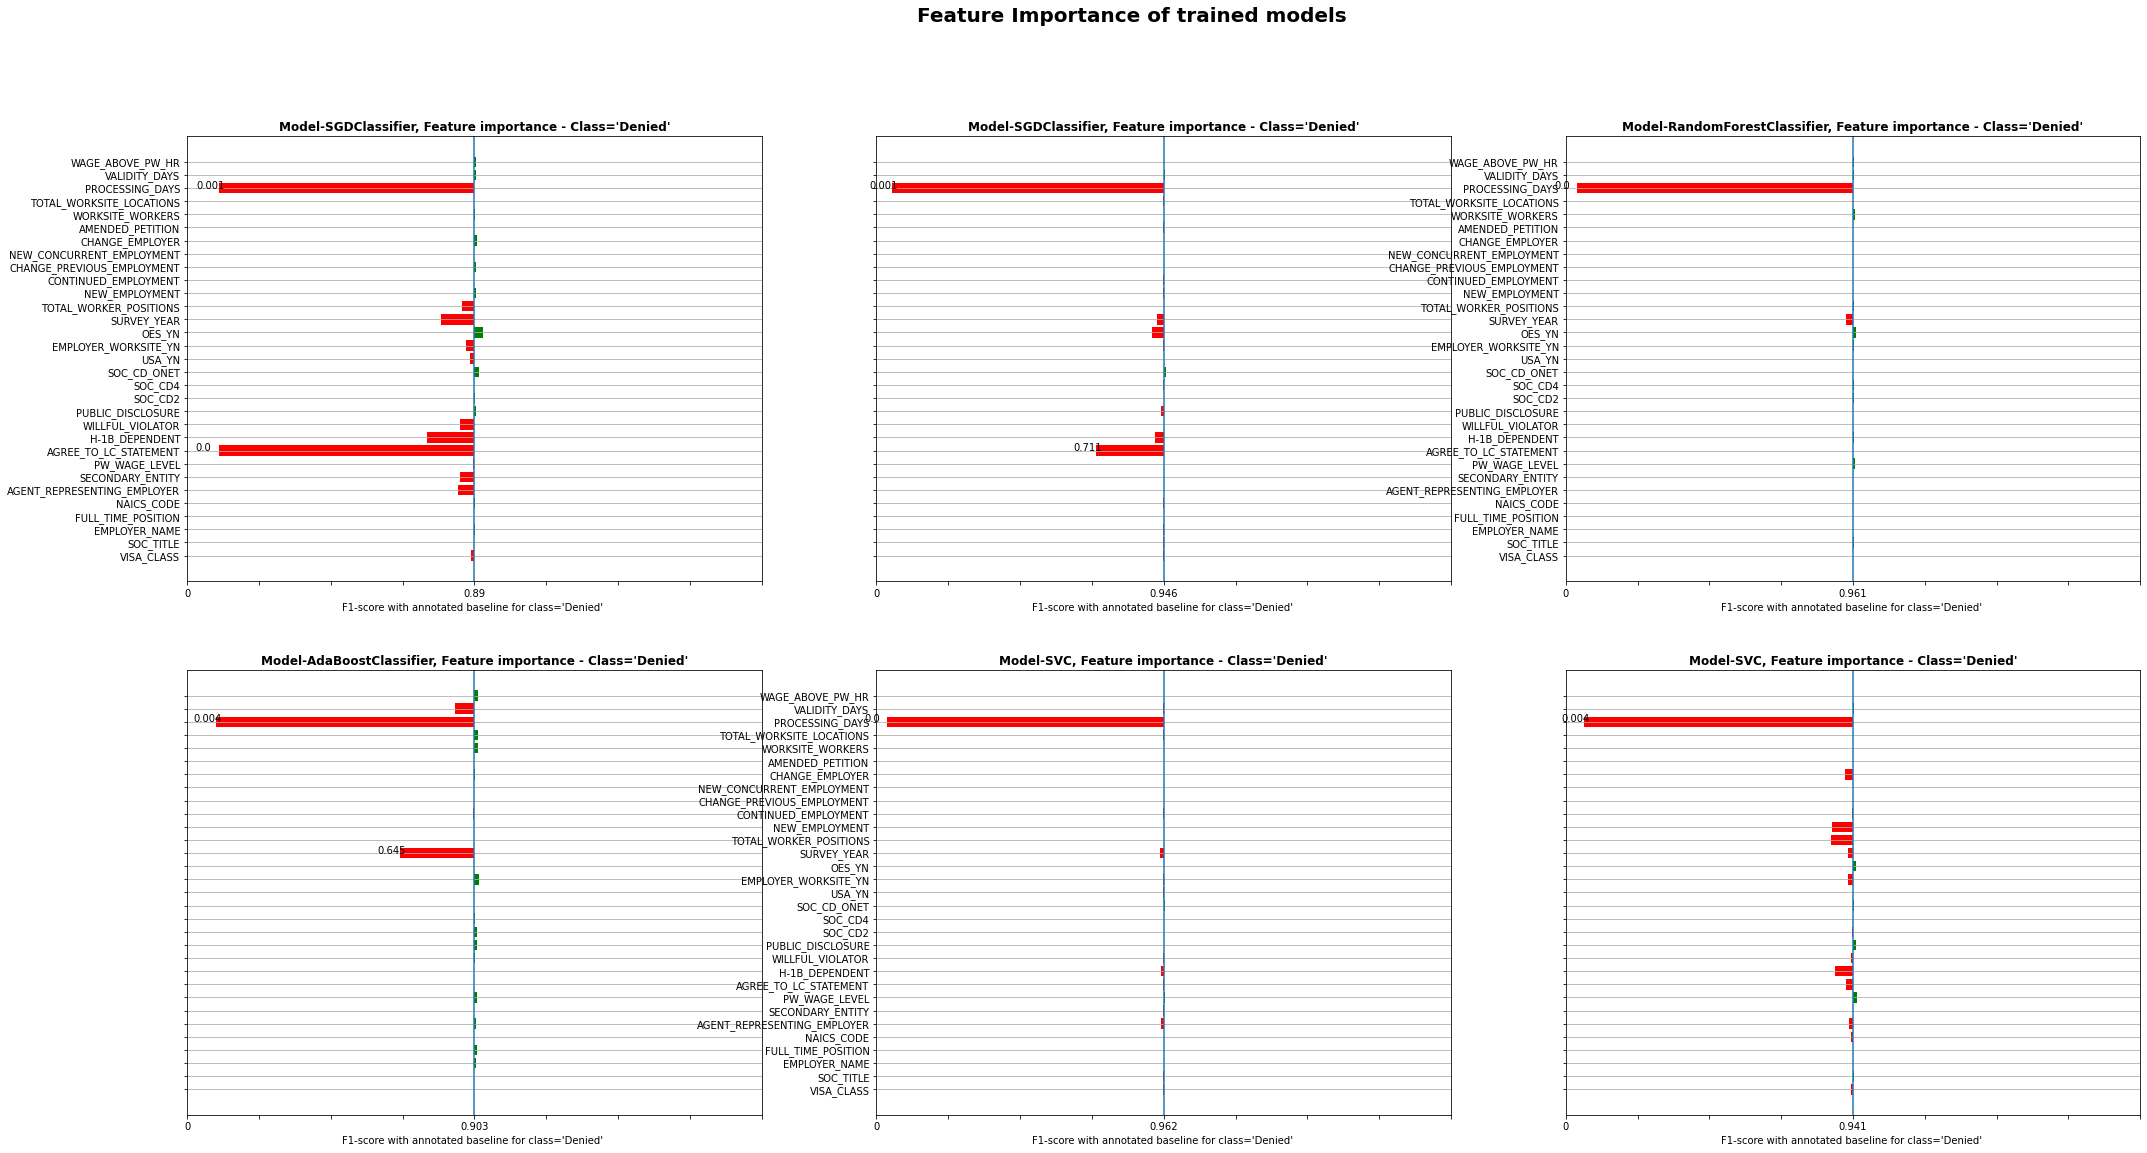

In [34]:
#for model in [svc,logistic,rfc,adaboost]:
j=0
fig = plt.figure(figsize=(35,18))
fig.suptitle('Feature Importance of trained models', fontsize=20, fontweight='bold')
model_name=['SVC_linear','Logistic','RandomForest','AdaBoost','SVC_rbf','SVC_poly']
for model in [svc,logistic,rfc,adaboost,svc_rbf,svc_poly]:
#for model in [svc_rbf,svc_poly]:
  j+=1
  feature_importance_df=pd.DataFrame(columns=['model','feature','metrics','baseline_diff'])

  baseline=f1_score(y_true=y_test,y_pred=model.predict(X_test),average=None)
  #print('baseline: ',baseline)
  for i in range(X_test.shape[1]):
    hide_feature_map=np.ones((X_test.shape[1]))
    hide_feature_map[i]=0
    X_hide_map=hide_feature_map*X_test
    y_pred=model.predict(X_hide_map)
    feature_score=f1_score(y_true=y_test,y_pred=y_pred,average=None)
    feature_importance_df.loc[feature_importance_df.shape[0]]=[model_name[j-1],np.append(cat_cols,num_cols)[i],np.round(feature_score,3),np.round((feature_score-baseline),3)]
    #print('Feature removed: ',np.append(cat_cols,num_cols)[i],', metrics ',f1_score(y_true=y_test,y_pred=y_pred,average=None))
  
  class1_diff=np.array([feature_importance_df.baseline_diff.values[i][1] for i in range(X_test.shape[1])])
  class1_metric=np.array([feature_importance_df.metrics.values[i][1] for i in range(X_test.shape[1])])
  #fig = plt.figure(figsize=(15,10))
  ax = plt.subplot(2,3,j)
  ax.set_title('Model-' + model_name[j-1] + ', Feature importance - Class=\'Denied\'',fontweight='bold')
  ax.grid(True,axis='y')
  ax.set(xlim=(-1, 1))
  ax.set_xticklabels(['0','','','',str(round(baseline[1],3))])
  ax.set_xlabel('F1-score with annotated baseline for class=\'Denied\' ')
  ax.axvline(x=0)
  ax.barh(width=class1_diff,y=feature_importance_df.feature.values,color=['g' if class1_diff[i] > 0 else 'r' for i in range(len(class1_diff))])
  if j%3==0:
    plt.setp(ax, yticklabels=[])

  #annotate only if metric value changes overthreshold
  for i in range(len(class1_diff)) :
    if np.abs(class1_diff[i])>0.2:
      ax.annotate(str(class1_metric[i]), xy=(class1_diff[i], feature_importance_df.feature.values[i]),xytext=(class1_diff[i]-0.08, feature_importance_df.feature.values[i]))

fig.savefig('/content/drive/MyDrive/H1B_model_importance_plot.png')

### Model Selection
Although model performance on test dataset is the key selection criterion, the complexity and processing time for training and prediction are also important when multiple models have similar performance. Accurately modelling the underlying process is also an important factor in model selection.  
From the model performance table shown above, following conclusions can be drawn -  
1. Training on the entire dataset works much better than training on equi-distributed batches.  
2. Linear, non-linear classification models and tree based models have better class 1 F1-score compared to clustering and anomaly detection based models.  
3. From the training and prediction time values, we observe that for similar performance, the linear models take less time than non-linear and tree based models.  

From the feature importance charts, following conclusions can be drawn -  
1. The tree based models and all non-linear models base their prediction decision only on 1-3 important features, they ignore the information present in other features.  
2. The SVC linear model and logistic model has 6-8 features that it considers important that we actually expect to impact the decision in real life applications. It models the underlying process more accurately than others.  
  
Given these observations, **Logistic classifier implemented using SGDClassifier(loss='log') is selected as the predictor.**   

### Model tuning

In [18]:
from sklearn.model_selection import GridSearchCV

In [39]:
logistic=SGDClassifier(loss='log',random_state=42,n_jobs=-1)
param_grid={'penalty':['l1','l2','elasticnet'],
            'alpha':[0.0001,0.001,0.01],
            'average':[True,False],
            'l1_ratio':[0.1,0.15,0.2,0.3]}

In [40]:
#full training dataset
X_train=train_df.copy()
y_train=X_train.pop('CASE_STATUS')
grid=GridSearchCV(estimator=logistic,param_grid=param_grid,scoring='f1_weighted')
grid.fit(X_train,y_train)
print(f1_score(y_true=y_test,y_pred=grid.predict(X_test),average=None))

[0.99954475 0.94682565]


In [41]:
print(pd.DataFrame(grid.cv_results_))
print(grid.best_estimator_)

   mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0       0.914764      0.073924  ...        0.000195                4
1       0.865466      0.089505  ...        0.000174                1
2       0.835573      0.060862  ...        0.000198                3
3       0.864725      0.082873  ...        0.000169                2

[4 rows x 17 columns]
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='elasticnet', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)


To find the best hyperparameters for our selected logistic classifier, grid search is performed for hyperparamters - penalty, alpha and average. **The model with penalty='elasticnet', l1_ratio=0.15, alpha='0.0001' and average='False' gives the best score and this will be used for this application.**  

### Other observations  
From the feature importance chart for linear SVC model, it can be observed that only a handful of features are important for classification whihc means that non-important features can be removed from the input without adversly impacting the model performance. Working with a subset of features will help reduce model size, training and prediction time.